# Autocorrelation and time series modeling
## Time series data

Repeated samples taken at regular time intervals

Allows us to examine trends over time, as well as noise in data

When dealing with time series information, a big focus is often to forecast future values. This can be quite difficult, as uncertainty is larger the further out into the future we go. 

Time series analysis is a very complicated field, and we are just going to scratch the surface of it. You could take a whole class just on time series analysis. 

In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

We are going to use data from World Bank that has mean annual air temperatures for the last 100+ years.

We're going to subset to data starting at 1970.

In [160]:
df = pd.read_csv('../data/usa-annual-temp.csv')
df = df.loc[df['year']>=1970,:]
df.head()

,year,temp
69,1970,8.53
70,1971,8.29
71,1972,8.19
72,1973,8.75
73,1974,8.67


Before we get started, we're going to convert year values to the data type datetime.

We will also set our index (row names) to be the year values. 

In [161]:
df['year'] = pd.to_datetime(df['year'], format='%Y')
df = df.set_index('year').sort_index() # makes sure years are in order
df.head()

,temp
year,
1970-01-01,8.53
1971-01-01,8.29
1972-01-01,8.19
1973-01-01,8.75
1974-01-01,8.67


With this done, we can visualize the time series as a line plot. 

Text(0, 0.5, 'Temp (C)')

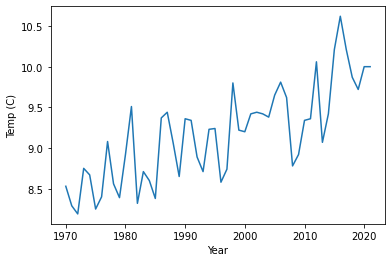

In [162]:
fig, ax = plt.subplots()
ax.plot(df['temp']);
ax.set_xlabel('Year')
ax.set_ylabel('Temp (C)')

The temperature appears to be increasing over time, but it is not constantly increasing. 

## Autocorrelation

Time series data has an important feature: it is sequential, meaning that we know the values before and after a given data point. 

Data points that are close together in time are likely to be correlated. This is a good starting point for our analysis. 

What we can do is calculate the correlation between our data points and the values directly before them. This is called **autocorrelation**: correlating our data with itself.

Specifically, we are going to see how much data from a given year is correlated with the data in the following year. 

In [163]:
from scipy.stats import pearsonr

lag = 1 # how many years removed?

# current year
temp_t = df['temp'][:len(df)-lag]

# one year prior
temp_t1 = df['temp'][lag:]

# calcualte correlation
r, p = pearsonr(temp_t, temp_t1)
print('correlation:', r)
print('p-value:', p)

correlation: 0.6544677365076538
p-value: 1.897183171125361e-07


We can plot an **autocorrelation function** (ACF) that shows the autocorrelation for various lags. 

Significant autocorrelation is the points above or below the highlighted blue zone. 

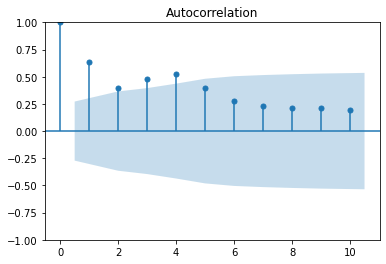

In [164]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df, lags=10);

## Stationarity: Augmented Dickey-Fuller Test (ADF Test)

Before we can model our time series, we need our data to be **stationary**: the mean and variance of the data have to be constant across the time series.

Looking at our data, it is pretty safe to conclude it is not stationary -> the mean increases as time passes.

However, to concretely test this, we can use the ADF test. 

In [165]:
from statsmodels.tsa.stattools import adfuller

adfuller(df)

(-1.1234308926873058,
 0.7056380702885359,
 3,
 48,
 {'1%': -3.5745892596209488,
  '5%': -2.9239543084490744,
  '10%': -2.6000391840277777},
 48.70255144202497)

Unfortunately, the output from this function is pretty overwhelming. Here's a function to make it look a bit more clear.

The important part here is the p-value, which represents the probability of observing this time series if the true process is not stationary. 

Because our p-value is quite large, we have to accept the null hypothesis that our time series is not stationary. 

In [166]:
def adf_print(time_series):
    adf_output = adfuller(time_series)
    stat = adf_output[0]
    pval = adf_output[1]
    print('ADF Statistic:', stat)
    print('p-value:', pval)
    return None

adf_print(df)

ADF Statistic: -1.1234308926873058
p-value: 0.7056380702885359


### Regression to quantify trend

If the time series is not stationary, it likely has a trend. In our case, the trend is linear, so we can use linear regression to quantify the trend.

If your data has a trend that is not linear, you can consider transformation, or breaking your time series into pieces that have linear trends. 

In [167]:
from statsmodels.formula.api import ols

df1 = pd.read_csv('../data/usa-annual-temp.csv')
df1 = df1.loc[df1['year']>=1970,:]


model = ols(formula="temp~year", data=df1).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   temp   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     78.33
Date:                Wed, 19 Apr 2023   Prob (F-statistic):           8.28e-12
Time:                        09:04:24   Log-Likelihood:                -20.838
No. Observations:                  52   AIC:                             45.68
Df Residuals:                      50   BIC:                             49.58
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -50.9498      6.793     -7.501      0.000     -64.593     -37.306
year           0.0301      0.003      8.850      0.000       0.023       0.037
==============================================================================
Omnibus:                        0.254   Durbin-Watson:                   1.717
Prob(Omnibus):                  0.881   Jarque-Bera (JB):                0.442
Skew:                           0.096   Prob(JB):                        0.802
Kurtosis:                       2.592   Cond. No.                     2.65e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.65e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Differencing

We need to remove the trend from our data. There are several ways to do this, but one of the most reliable ways is to use **differencing** to transform it. 

Differencing is simply subtracting each value in the time series by the subsequent value.

In [168]:
y_diff = df['temp'].diff().dropna()


We can visualize our time series and see it is now stationary. 

Text(0, 0.5, 'Temp (differenced)')

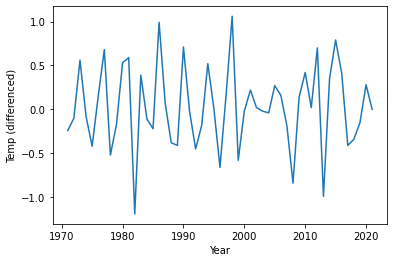

In [169]:
fig, ax = plt.subplots()
ax.plot(y_diff)
ax.set_xlabel('Year')
ax.set_ylabel('Temp (differenced)')

To be sure, we can run the ADF test again, as well. 

In [170]:
adf_print(y_diff)

ADF Statistic: -5.473870817487465
p-value: 2.3654706497866075e-06


We can now revisit our ACF plot and see how it has changed now.  

You can see the only significant lag is now 2. 

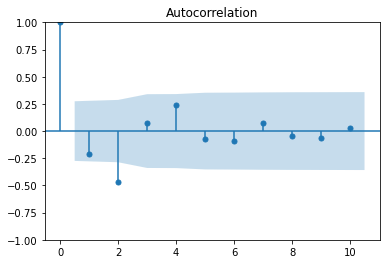

In [171]:
plot_acf(y_diff, lags=10);

There is a similar plot called a partial autocorrelation function (PACF). It is similar but has a slightly different interpretation. For more information, please see [this article](https://www.linkedin.com/pulse/time-series-analysis-short-introduction-/?trk=pulse-article).

Our PACF has significant lags of 2, 3, and 10. 

/Users/fordfishman/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


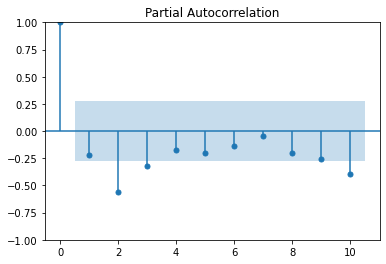

In [172]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(y_diff, lags=10);

Let's use the fact that we have significant autocorrelation try to make a model.

We're going to use previous timepoints to predict later values. We can start by using data from the previous year to predict the current year.

We're going to multiply the previous value by some number to predict the value for the current year.

We can do the same with a lag of 2 as well.

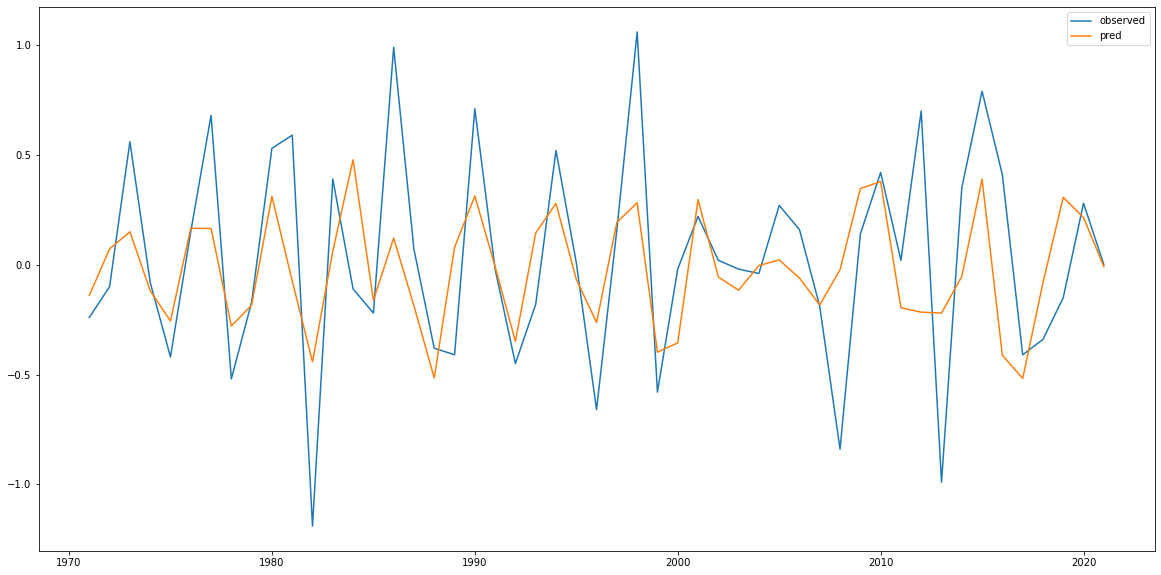

0.15693623529411757


In [183]:
predictions = []
b1 = -0.3
b2 = -0.5

for i in range(len(y_diff)):
    
    y_p = b1*y_diff[i-1] + b2*y_diff[i-2]
    predictions.append(y_p)

predictions_s = pd.Series(predictions, index=y_diff.index)

fig, ax = plt.subplots(figsize=(20,10)) 
ax.plot(y_diff, label='observed')
ax.plot(predictions_s, label='pred')
ax.legend()
plt.show()

mean_squared_error = np.mean((y_diff-predictions_s)**2)

print(mean_squared_error)

### Question

In groups, using the code in the cell above, try to make a model with the smallest mean squared error. 

This is a manual version of an **autoregressive (AR) model**. statsmodels has a function `AutoReg` to do the fitting process for us. 

If we use 1 lag term, we call our model an AR(1) model. If we use 3 lag terms, we call our model an AR(3) model. 

In [174]:
from statsmodels.tsa.ar_model import AutoReg

ar_model = AutoReg(y_diff, lags=3).fit()

ar_model.summary()

/Users/fordfishman/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                   temp   No. Observations:                   51
Model:                     AutoReg(3)   Log Likelihood                 -21.881
Method:               Conditional MLE   S.D. of innovations              0.382
Date:                Wed, 19 Apr 2023   AIC                             53.763
Time:                        09:04:25   BIC                             63.119
Sample:                    01-01-1974   HQIC                            57.299
                         - 01-01-2021                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0712      0.056      1.271      0.204      -0.039       0.181
temp.L1       -0.4854      0.137     -3.542      0.000      -0.754      -0.217
temp.L2       -0.6282      0.124     -5.075      0.000      -0.871      -0.386
temp.L3       -0.2900      0.137     -2.119      0.034      -0.558      -0.022
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.0142           -1.2700j            1.2700           -0.2518
AR.2           -0.0142           +1.2700j            1.2700            0.2518
AR.3           -2.1380           -0.0000j            2.1380           -0.5000
-----------------------------------------------------------------------------
"""

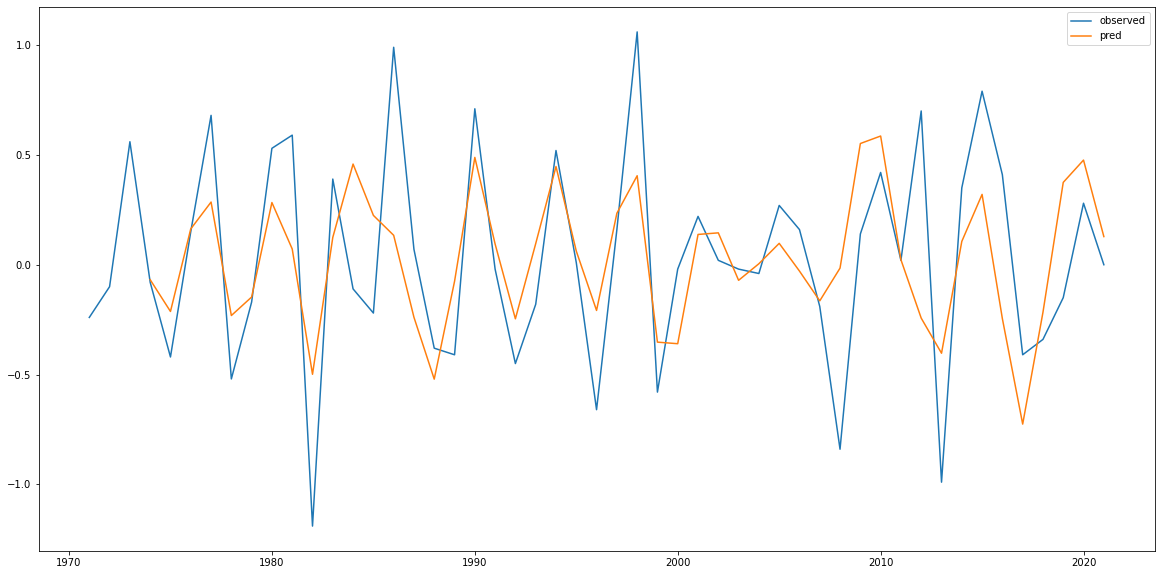

In [175]:
y_pred = ar_model.predict()

fig, ax = plt.subplots(figsize=(20,10)) 
ax.plot(y_diff, label='observed')
ax.plot(y_pred, label='pred')
ax.legend();

## MA model

Another way to model a time series is with a **moving average** model. Instead of using prior values, we use prior error: how much off our predictions were in previous years. 

To see how many years to look at, we can look at the ACF plot. For our first example, we'll just look at the most recent error. 

0.14317439446366761


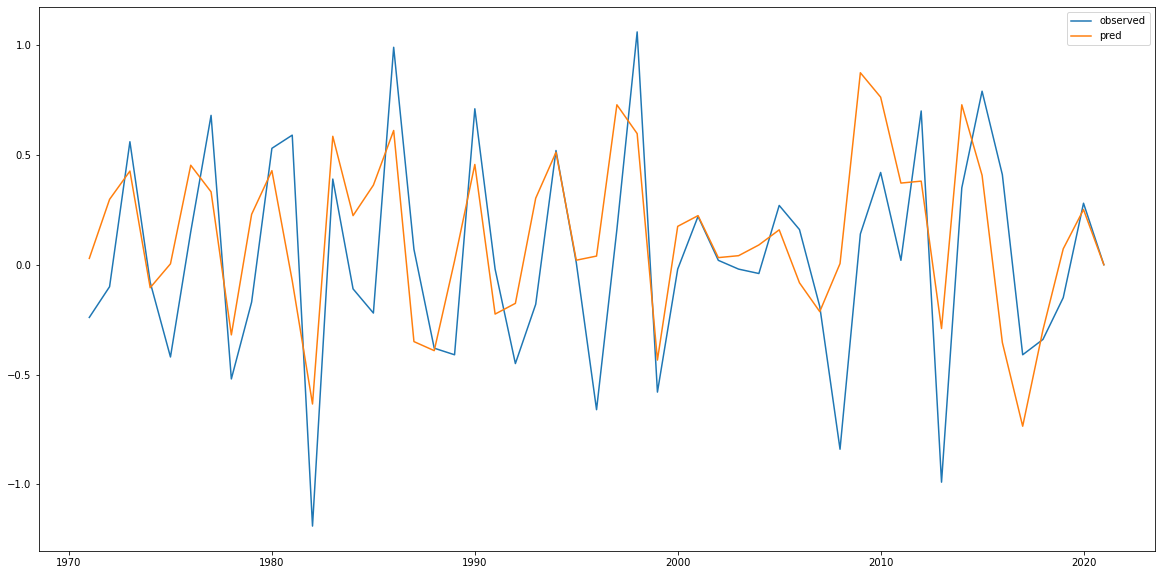

In [189]:
mu = np.mean(y_diff)
predictions = [mu]
b1 = -0.5

for i in range(len(y_diff)-1):
    
    last_diff = y_diff[i] - predictions[i]
    y_p = mu + b1*last_diff
    
    predictions.append(y_p)

predictions_s = pd.Series(predictions, index=y_diff.index)

fig, ax = plt.subplots(figsize=(20,10)) 
ax.plot(y_diff, label='observed')
ax.plot(predictions_s, label='pred')
ax.legend();

mean_squared_error = np.mean((y_diff-predictions_s)**2)

print(mean_squared_error)

Similar to AR models, we can use some functions to calculate coefficients for us. The one we will use is called ARIMA (more on this later).

In the `order` parameter of the model, we specify how many error terms we will use. If we use 2 error terms, it is an MA(2) model. 

In [192]:
from statsmodels.tsa.arima.model import ARIMA

# Fit an MA(2) model to the first simulated data
ma_model = ARIMA(y_diff, order=(0,0,1)).fit()

# Print out summary information on the fit
print(ma_model.summary())


                               SARIMAX Results                                
Dep. Variable:                   temp   No. Observations:                   51
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 -22.908
Date:                Wed, 19 Apr 2023   AIC                             51.816
Time:                        09:15:47   BIC                             57.611
Sample:                    01-01-1971   HQIC                            54.030
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0301      0.005      6.182      0.000       0.021       0.040
ma.L1         -1.0000    109.845     -0.009      0.993    -216.293     214.293
sigma2         0.1331     14.622      0.009      0.9

/Users/fordfishman/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/fordfishman/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/fordfishman/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


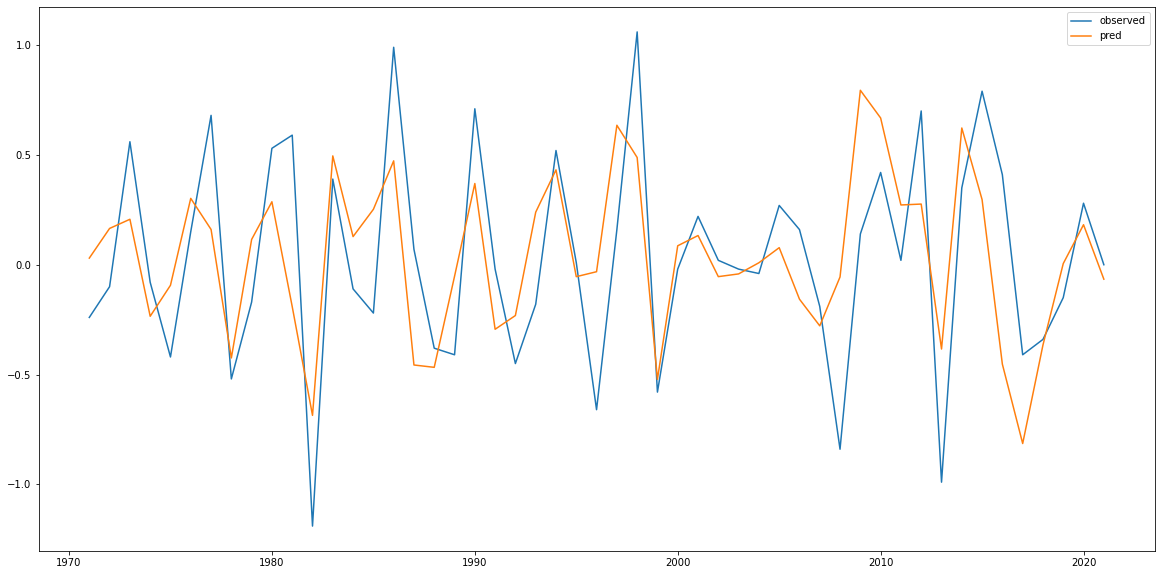

In [99]:
y_pred = ma_model.predict()

fig, ax = plt.subplots(figsize=(20,10)) 
ax.plot(y_diff, label='observed')
ax.plot(y_pred, label='pred')
ax.legend();

We can use both AR and MA terms in our model. This is called an ARMA model (we'll get to the I in just a second.)

/Users/fordfishman/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/fordfishman/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/fordfishman/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/fordfishman/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


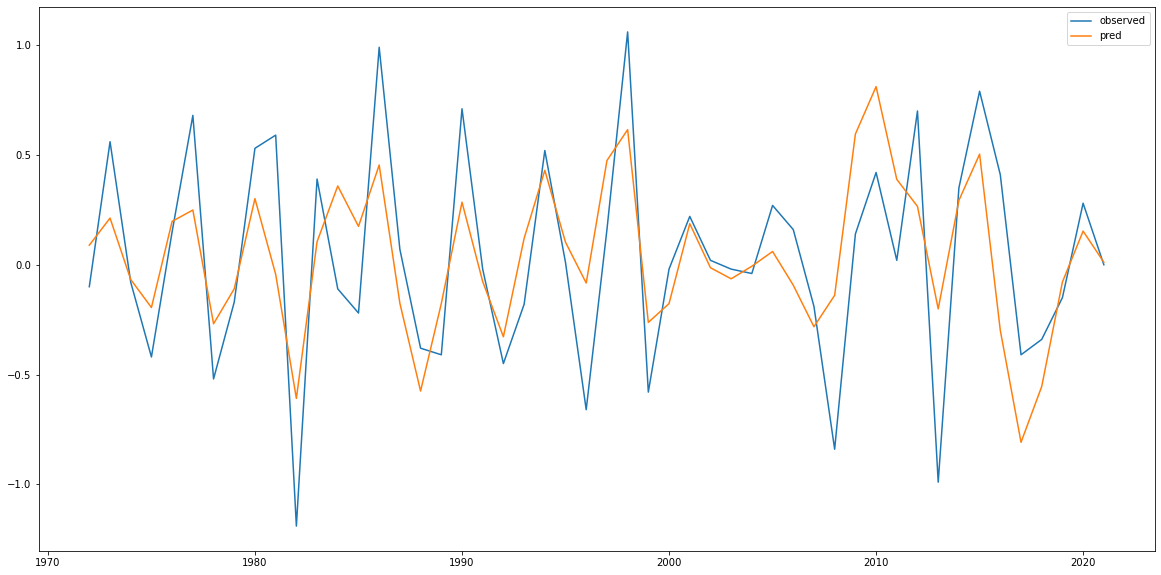

In [156]:
mod = ARIMA(y_diff, order=(2, 0, 2))
arma_model = mod.fit()

y_pred = arma_model.predict()

fig, ax = plt.subplots(figsize=(20,10)) 
ax.plot(y_diff[1:], label='observed')
ax.plot(y_pred[1:], label='pred')
ax.legend();

In [155]:
arma_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   temp   No. Observations:                   51
Model:               ARIMA([2], 0, 2)   Log Likelihood                 -18.484
Date:                Tue, 18 Apr 2023   AIC                             46.967
Time:                        22:26:22   BIC                             56.626
Sample:                    01-01-1971   HQIC                            50.658
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0300      0.005      6.561      0.000       0.021       0.039
ar.L2         -0.3249      0.160     -2.030      0.042      -0.639      -0.011
ma.L1         -0.7606     10.401     -0.073      0.942     -21.146      19.624
ma.L2         -0.2388      2.477     -0.096      0.923      -5.095       4.617
sigma2         0.1109      1.151      0.096      0.923      -2.144       2.366
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.71
Prob(Q):                              0.98   Prob(JB):                         0.70
Heteroskedasticity (H):               1.42   Skew:                            -0.19
Prob(H) (two-sided):                  0.48   Kurtosis:                         2.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## I: Integrated

The I in ARIMA stands for integrated. Basically, included a value for I does the differencing for us. This allows us to use our time series without detrending it first. 

/Users/fordfishman/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/fordfishman/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/fordfishman/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


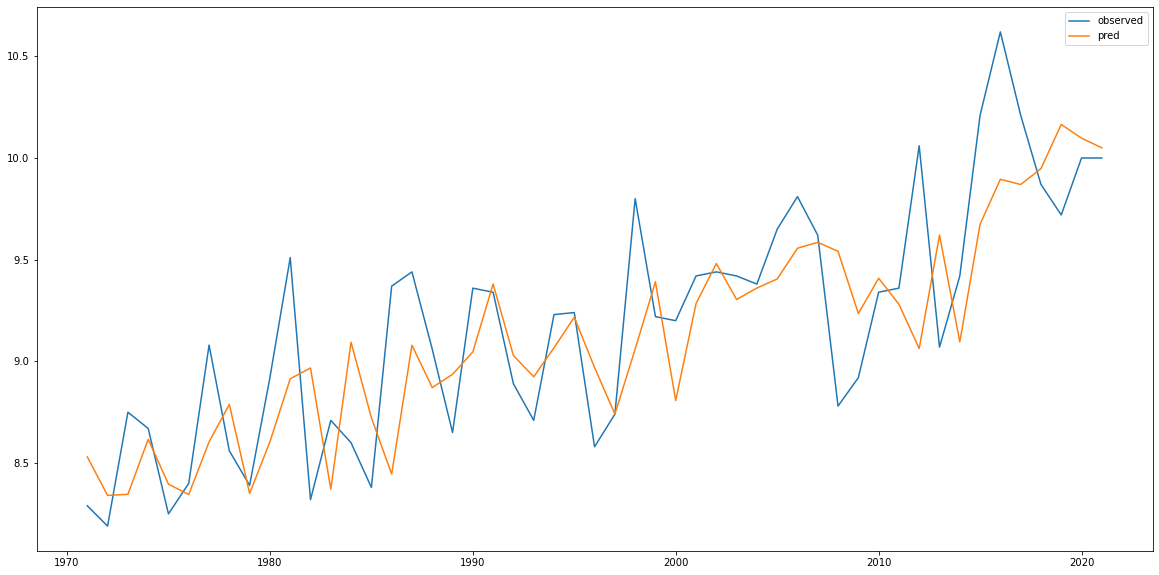

In [152]:
mod = ARIMA(df['temp'], order=(3, 1, 2))
arima_model = mod.fit()

y_pred = arima_model.predict()

fig, ax = plt.subplots(figsize=(20,10)) 
ax.plot(df['temp'][1:], label='observed')
ax.plot(y_pred[1:], label='pred')
ax.legend();

In [153]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   temp   No. Observations:                   52
Model:                 ARIMA(3, 1, 0)   Log Likelihood                 -23.701
Date:                Tue, 18 Apr 2023   AIC                             55.402
Time:                        22:18:07   BIC                             63.130
Sample:                    01-01-1970   HQIC                            58.355
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4552      0.135     -3.360      0.001      -0.721      -0.190
ar.L2         -0.5995      0.118     -5.065      0.000      -0.832      -0.368
ar.L3         -0.2573      0.142     -1.816      0.069      -0.535       0.020
sigma2         0.1458      0.028      5.257      0.000       0.091       0.200
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):                 0.57
Prob(Q):                              0.64   Prob(JB):                         0.75
Heteroskedasticity (H):               1.18   Skew:                             0.26
Prob(H) (two-sided):                  0.74   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Choosing the correct model is difficult. Next time, we will use a better method for picking the correct ARIMA model, as well as how to forecast, and deal with seasonal data. 

In [157]:
# mean squared error
arima_model.mse

0.11798749298287803

### Question
In groups, try several different kinds of ARIMA models -> different amounts of AR, I, and MA terms. What combinations lead to the smallest mean squared error?